In [1]:
import pandas as pd 
import numpy as np 
from tqdm import tqdm 
from plotnine import *
import plotly
import matplotlib.pyplot as plt 
from pandas_profiling import ProfileReport
from bball_reference import BBallScrape

pd.set_option("display.max_rows", 10000, "display.max_columns", 10000)


In [2]:
def FormatTeams(df): 
    
    df.team = df.team.str.strip().str.replace(' ', '_').str.lower().str.replace(
                '\*', '')

    return df

In [3]:

def ConvertCols(x): 
    column = np.array(x.fillna('100000-11').str.split('-').to_list())
    column = column.astype(np.float) 
    wins = column.T[0] 
    losses = column.T[1]

    
    return wins / np.add(wins, losses) 

In [4]:
def ReadData(first_year, last_year): 

    

    try: 
        standings = pd.read_excel('csv_files/standings.xlsx') 
        team = pd.read_excel('csv_files/team_stats.xlsx') 
        opponent = pd.read_excel('csv_files/opponent_stats.xlsx') 

    except: 

        scrape = BBallScrape(first_year) 

        standings = scrape.Standings()
        team, opponent = scrape.TeamStats()

        for year in tqdm(range((first_year+1), (last_year + 1))): 
            print(year)
            scrape = BBallScrape(year) 

            standings = standings.append(scrape.Standings())
            team_new, opponent_new = scrape.TeamStats()
            team = team.append(team_new) 
            opponent = opponent.append(opponent_new) 
        

        standings.to_excel('csv_files/standings.xlsx')
        team.to_excel('csv_files/team_stats.xlsx')
        opponent.to_excel('csv_files/opponent_stats.xlsx') 

    standings.columns = standings.columns.str.lower() 
    team.columns = team.columns.str.lower()
    opponent.columns = opponent.columns.str.lower()

    standings['year'] = standings.year_x

    SubsetYears = lambda x: x[(x.year >= first_year) & (x.year <= last_year)]

    team = SubsetYears(team) 
    opponent = SubsetYears(opponent) 
    standings = SubsetYears(standings) 

    return team[(team.year >= first_year) & (team.year <= last_year)], opponent, standings 

#team, opponent, standings = ReadData(2000, 2019)


In [5]:
def FormatStandings(standings): 



    f_standings = standings[~standings.th.str.contains('Division', na = False) ].copy()

     

    f_standings['year'] = f_standings.year_x.astype(int) 
    f_standings = f_standings.drop(columns = ['year_x', 'year_y', 'th', 
                                        'w', 'l', 'w/l%', 'gb', 'ps/g', 
                                        'pa/g', 'srs', 'playoffs', 'unnamed: 0'])

    f_standings.columns = f_standings.columns.str.lower() 

    f_standings = FormatTeams(f_standings) 

    f_standings = f_standings.dropna(how = 'all', axis = 1) 

    f_standings = pd.concat([
        f_standings[['team', 'year']], f_standings.iloc[:,1:-1].transform(ConvertCols)
    ], axis = 1)

    f_standings = f_standings.replace(f_standings.iloc[0,2], np.NaN)
    f_standings.index = f_standings.team 
    f_standings = f_standings.drop(columns = ['team'])
    f_standings = f_standings[~f_standings.index.isna()]


    return f_standings 

#standings = FormatStandings(standings) 

In [6]:
def MatchColNames(df, year): 
        df_year = df[df.year == year].copy()

        df_year = df_year.dropna(how = 'all', axis = 1) 

        names = [] 

        for col in df: 
            try: 
                names.append(df_year[df_year[col].isna()].index.to_list()[0])
            except: 
                pass
        
        df_year.columns = ['year'] + names 
        return df_year 

def FilterCols(df): 

    

    years = df.year.unique() 
    df_year = MatchColNames(df, years[0])


    for year in years[1:]: 
        print(year) 
        df_year = df_year.append(MatchColNames(df, year))

    return df_year 

#standings = FilterCols(standings) 

In [7]:
from sklearn.preprocessing import MinMaxScaler

def FormatStats(df, offense): 
    df.dropna(how = 'any', inplace = True)
    df['playoffs'] = df.team.str.contains('\*', regex = True).astype('int')
    df_group = FormatTeams(df)
    df_group = df.drop(columns = ['unnamed: 0', 'playoffs', 'g', 'mp'])
    df_group = df_group.groupby(['year'])
    df_group = df_group.transform(lambda x: (x - x.mean())/(x.std())) 
    #df_group = df_group.drop(columns = ['level_0', 'index'])
    df_group[df_group.columns] = MinMaxScaler().fit_transform(df_group) 
    
    

    if offense is True: 
        o_d = 'offense_'
    else: 
        o_d = 'defense_'

    df_group.columns = [o_d + str(col) for col in df_group.columns]

    df_playoff = pd.concat(
        [df[['team', 'year']], df_group, df['playoffs']], axis = 1
    )

    df = df_playoff.drop(columns = ['playoffs'])



   
    
    return df

#team = FormatStats(team)
#opponent = FormatStats(opponent) 

In [8]:
def TeamWin(x): 
    if x < 0.4: 
        a = 0
    elif x <= 0.6: 
        a = 1
    else: 
        a = 2
    return a

In [9]:
def GamePredictions(standings, team_data): 
    df = standings.copy() 


    game_predictions = pd.DataFrame(columns = ['team', 'opponent', 'year', 'team_win'])

    for year in standings.year.unique(): 
        standings_year = df[df.year == year] 

        team_names = standings_year.index.unique().to_numpy() 

        for first_name in team_names: 
            for second_name in team_names: 

                try: 
                    team_win = standings_year.unstack()[first_name][second_name]
                except: 
                    print(year, first_name, second_name) 
                    team_win = None
                    pass

                game_predictions = game_predictions.append({
                    'team': first_name, 
                    'opponent': second_name, 
                    'year': int(year), 'team_win': team_win
                    }, ignore_index=True)

    game_predictions = game_predictions.dropna() 
    game_predictions['year'] = game_predictions.year.astype(str) 
    game_predictions['both_teams'] = game_predictions.apply(lambda x: sorted(x[['team', 'opponent', 'year']]), axis = 1) 
    game_predictions = game_predictions.groupby(game_predictions.both_teams.apply(tuple, 1)).first().reset_index(drop = True) 
    game_predictions = game_predictions.drop(columns = ['both_teams']).reset_index().drop(columns = ['index'])
    game_predictions['year'] = game_predictions.year.astype(int)

    game_predictions = game_predictions.merge(
        team_data, on = ['team', 'year'])
    game_predictions = game_predictions.merge(
        team_data, left_on = ['opponent', 'year'], right_on = ['team', 'year']
    )
    game_predictions = game_predictions.drop(columns = ['team_y'])
    game_predictions = game_predictions.rename({'team_x': 'team'}, axis = 'columns')

    game_predictions['team_win'] = game_predictions.team_win.transform(TeamWin)

    return game_predictions

#game_predictions = GamePredictionY(standings) 

In [10]:
team, opponent, standings = ReadData(2000, 2019) 
standings = FormatStandings(standings) 
team_formatted = FormatStats(team, True)
opponent_formatted = FormatStats(opponent, False) 
standings = FilterCols(standings) 
game_predictions_offense = GamePredictions(standings, team) 
game_predictions_defense = GamePredictions(standings, opponent) 




2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019


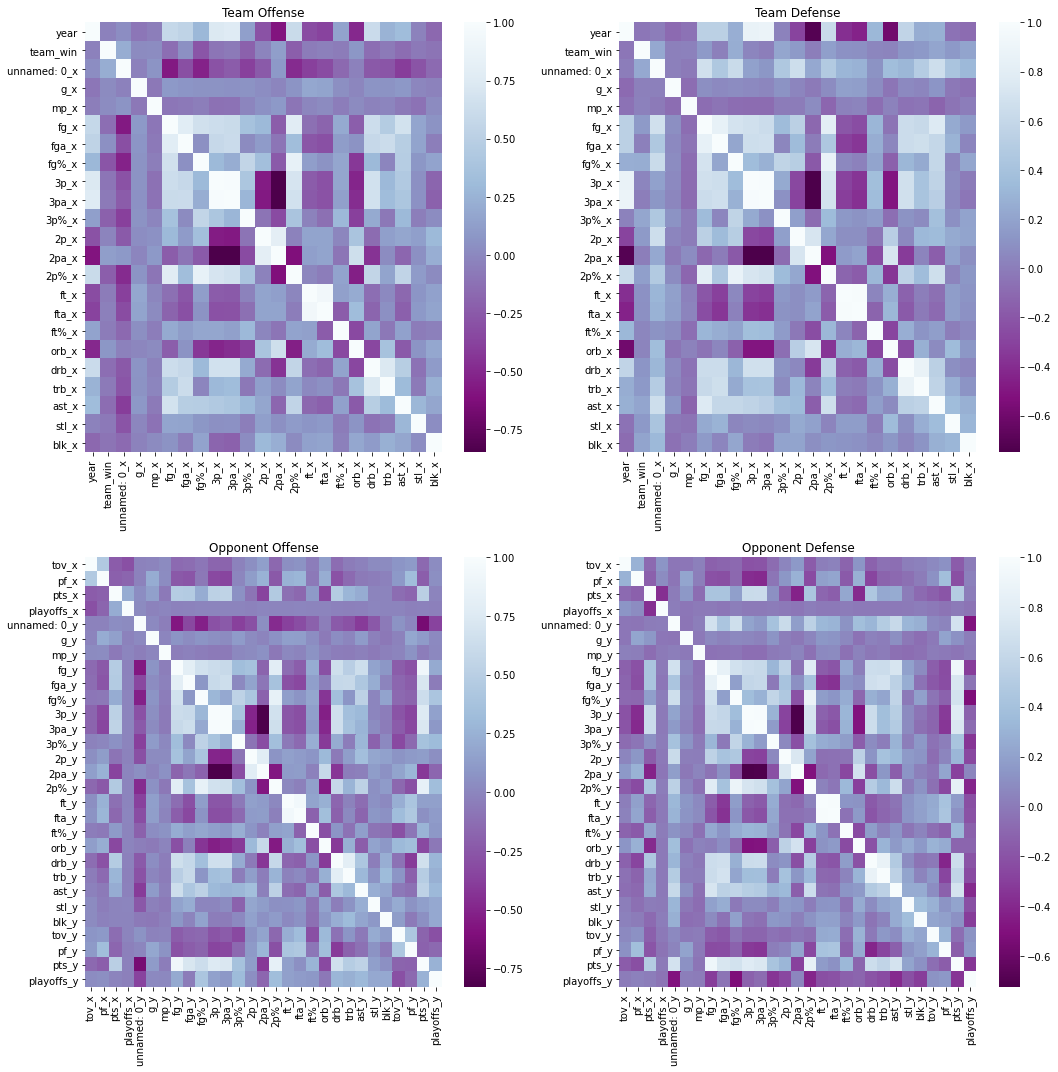

In [11]:
import seaborn as sns
fig, ax= plt.subplots(2, 2, figsize = (15, 15)) 

offense_defense_cutoff = 25


sns.heatmap(
    game_predictions_offense.iloc[:,:offense_defense_cutoff].corr(), ax = ax[0, 0], cmap = 'BuPu_r'
    ).set_title('Team Offense')
sns.heatmap(
    game_predictions_offense.iloc[:,offense_defense_cutoff:].corr(), ax = ax[1, 0], cmap = 'BuPu_r'
).set_title('Opponent Offense')

sns.heatmap(
    game_predictions_defense.iloc[:,:offense_defense_cutoff].corr(), ax = ax[0, 1], cmap = 'BuPu_r'
    ).set_title('Team Defense')
sns.heatmap(
    game_predictions_defense.iloc[:,offense_defense_cutoff:].corr(), ax = ax[1, 1], cmap = 'BuPu_r'
).set_title('Opponent Defense')

fig.tight_layout()

plt.show()


In [12]:
game_predictions_offense.head()

,team,opponent,year,team_win,unnamed: 0_x,g_x,mp_x,fg_x,fga_x,fg%_x,3p_x,3pa_x,3p%_x,2p_x,2pa_x,2p%_x,ft_x,fta_x,ft%_x,orb_x,drb_x,trb_x,ast_x,stl_x,blk_x,tov_x,pf_x,pts_x,playoffs_x,unnamed: 0_y,g_y,mp_y,fg_y,fga_y,fg%_y,3p_y,3pa_y,3p%_y,2p_y,2pa_y,2p%_y,ft_y,fta_y,ft%_y,orb_y,drb_y,trb_y,ast_y,stl_y,blk_y,tov_y,pf_y,pts_y,playoffs_y
0,atlanta_hawks,boston_celtics,2000,2,24,82.0,241.8,36.6,83.0,0.441,3.1,9.9,0.317,33.4,73.1,0.458,18.0,24.2,0.743,14.0,31.3,45.3,18.9,6.1,5.6,15.4,21.0,94.3,0,8,82.0,240.6,37.2,83.9,0.444,5.1,15.4,0.331,32.2,68.5,0.469,19.8,26.5,0.745,13.5,29.5,43.0,21.2,9.7,3.5,15.4,27.1,99.3,0
1,atlanta_hawks,charlotte_hornets,2000,2,24,82.0,241.8,36.6,83.0,0.441,3.1,9.9,0.317,33.4,73.1,0.458,18.0,24.2,0.743,14.0,31.3,45.3,18.9,6.1,5.6,15.4,21.0,94.3,0,13,82.0,241.2,35.8,79.7,0.449,4.1,12.2,0.339,31.7,67.5,0.469,22.7,30.0,0.758,10.8,32.1,42.9,24.7,8.9,5.9,14.7,20.4,98.4,1
2,boston_celtics,charlotte_hornets,2000,2,8,82.0,240.6,37.2,83.9,0.444,5.1,15.4,0.331,32.2,68.5,0.469,19.8,26.5,0.745,13.5,29.5,43.0,21.2,9.7,3.5,15.4,27.1,99.3,0,13,82.0,241.2,35.8,79.7,0.449,4.1,12.2,0.339,31.7,67.5,0.469,22.7,30.0,0.758,10.8,32.1,42.9,24.7,8.9,5.9,14.7,20.4,98.4,1
3,atlanta_hawks,chicago_bulls,2000,0,24,82.0,241.8,36.6,83.0,0.441,3.1,9.9,0.317,33.4,73.1,0.458,18.0,24.2,0.743,14.0,31.3,45.3,18.9,6.1,5.6,15.4,21.0,94.3,0,28,82.0,241.5,31.3,75.4,0.415,4.1,12.6,0.329,27.1,62.8,0.432,18.1,25.5,0.709,12.6,28.3,40.9,20.1,7.9,4.7,19.0,23.3,84.8,0
4,boston_celtics,chicago_bulls,2000,1,8,82.0,240.6,37.2,83.9,0.444,5.1,15.4,0.331,32.2,68.5,0.469,19.8,26.5,0.745,13.5,29.5,43.0,21.2,9.7,3.5,15.4,27.1,99.3,0,28,82.0,241.5,31.3,75.4,0.415,4.1,12.6,0.329,27.1,62.8,0.432,18.1,25.5,0.709,12.6,28.3,40.9,20.1,7.9,4.7,19.0,23.3,84.8,0


In [18]:
cols = [col for col in game_predictions_offense.columns if '2' not in col] 
cols = [col for col in cols if 'a_' not in col] 
game_predictions_offense[cols].head()

def FilterCols(df): 
    '''Remove 2point stats, and all attempts from data''' 
    cols = [col for col in df.columns if '2' not in col]
    cols = [col for col in cols if 'a_' not in col] 
    df = df[cols]
    df.columns = df.columns.str.replace('_x', '').str.replace('_y', '')


    return  df

predictions_offense_filtered = FilterCols(game_predictions_offense) 
predictions_defense_filtered = FilterCols(game_predictions_defense) 
predictions_total = predictions_offense_filtered.merge(
    predictions_defense_filtered, on = ['team', 'opponent', 'year', 'team_win']
)

predictions_offense_filtered.to_csv('csv_files/game_predictions_offense.csv') 
predictions_defense_filtered.to_csv('csv_files/game_predictions_defense.csv') 
predictions_total.to_csv('csv_files/game_predictions_total.csv')

In [14]:
predictions_defense_filtered.head()

,team,opponent,year,team_win,unnamed: 0,g,mp,fg,fg%,3p,3p%,ft,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,playoffs,unnamed: 0,g,mp,fg,fg%,3p,3p%,ft,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,playoffs
0,atlanta_hawks,boston_celtics,2000,2,17,82.0,241.8,39.2,0.455,4.5,0.367,16.8,0.769,12.8,30.2,43.0,23.0,8.0,4.9,12.2,22.3,99.7,0,19,82.0,240.6,36.1,0.470,4.4,0.361,23.5,0.753,10.5,30.9,41.4,21.9,7.8,5.8,17.0,23.5,100.1,0
1,atlanta_hawks,charlotte_hornets,2000,2,17,82.0,241.8,39.2,0.455,4.5,0.367,16.8,0.769,12.8,30.2,43.0,23.0,8.0,4.9,12.2,22.3,99.7,0,9,82.0,241.2,37.2,0.448,5.0,0.378,16.4,0.745,11.8,31.1,42.9,23.2,7.4,5.1,15.8,25.3,95.8,1
2,boston_celtics,charlotte_hornets,2000,2,19,82.0,240.6,36.1,0.470,4.4,0.361,23.5,0.753,10.5,30.9,41.4,21.9,7.8,5.8,17.0,23.5,100.1,0,9,82.0,241.2,37.2,0.448,5.0,0.378,16.4,0.745,11.8,31.1,42.9,23.2,7.4,5.1,15.8,25.3,95.8,1
3,atlanta_hawks,chicago_bulls,2000,0,17,82.0,241.8,39.2,0.455,4.5,0.367,16.8,0.769,12.8,30.2,43.0,23.0,8.0,4.9,12.2,22.3,99.7,0,8,82.0,241.5,35.6,0.456,4.4,0.341,18.7,0.741,12.2,29.5,41.7,23.2,10.4,5.6,15.2,24.0,94.2,0
4,boston_celtics,chicago_bulls,2000,1,19,82.0,240.6,36.1,0.470,4.4,0.361,23.5,0.753,10.5,30.9,41.4,21.9,7.8,5.8,17.0,23.5,100.1,0,8,82.0,241.5,35.6,0.456,4.4,0.341,18.7,0.741,12.2,29.5,41.7,23.2,10.4,5.6,15.2,24.0,94.2,0


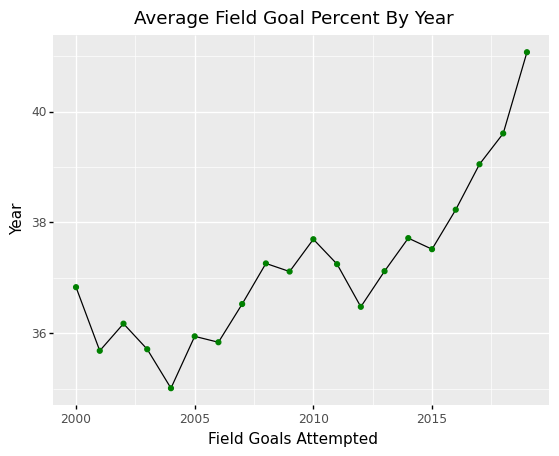

<ggplot: (8780333063566)>

In [15]:
ggplot(aes(x= 'year', y = 'fg'), data = team.groupby(['year']).mean().reset_index()) + geom_line() + geom_point(color = 'green') + labs(
    x = 'Field Goals Attempted', y = 'Year', title = 'Average Field Goal Percent By Year'
)

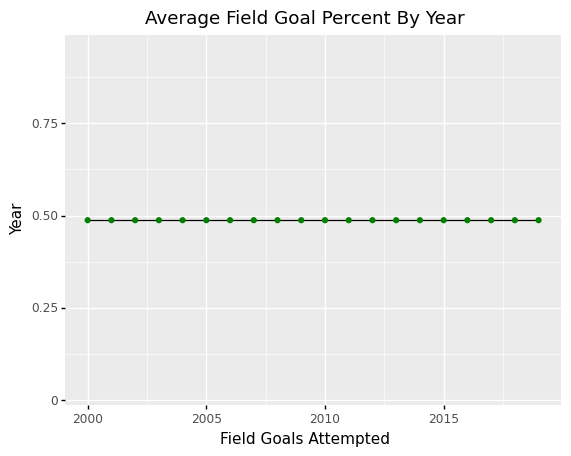

<ggplot: (8780333094307)>

In [16]:
ggplot(aes(x= 'year', y = 'offense_fg'), data = team_formatted.groupby(['year']).mean().reset_index()) + geom_line() + geom_point(color = 'green') + labs(
    x = 'Field Goals Attempted', y = 'Year', title = 'Average Field Goal Percent By Year'
)


In [17]:
team.head()

,unnamed: 0,team,g,mp,fg,fga,fg%,3p,3pa,3p%,2p,2pa,2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,year,playoffs
0,0,sacramento_kings,82.0,241.5,40.0,88.9,0.450,6.5,20.2,0.322,33.4,68.7,0.487,18.5,24.6,0.754,12.9,32.1,45.0,23.8,9.6,4.6,16.2,21.1,105.0,2000,1
1,1,detroit_pistons,82.0,241.8,37.1,80.9,0.459,5.4,14.9,0.359,31.8,66.0,0.481,23.9,30.6,0.781,11.2,30.0,41.2,20.8,8.1,3.3,15.7,24.5,103.5,2000,1
2,2,dallas_mavericks,82.0,240.6,39.0,85.9,0.453,6.3,16.2,0.391,32.6,69.8,0.468,17.2,21.4,0.804,11.4,29.8,41.2,22.1,7.2,5.1,13.7,21.6,101.4,2000,0
3,3,indiana_pacers,82.0,240.6,37.2,81.0,0.459,7.1,18.1,0.392,30.0,62.8,0.478,19.9,24.5,0.811,10.3,31.9,42.1,22.6,6.8,5.1,14.1,21.8,101.3,2000,1
4,4,milwaukee_bucks,82.0,242.1,38.7,83.3,0.465,4.8,13.0,0.369,33.9,70.2,0.483,19.0,24.2,0.786,12.4,28.9,41.3,22.6,8.2,4.6,15.0,24.6,101.2,2000,1
